In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import re

In [4]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns',8000)
pd.set_option('display.max_rows',7000)

In [5]:
from google.colab import files
files.upload()

Saving jokes.csv to jokes.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [6]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
jokes=pd.read_csv('jokes.csv')

In [7]:
train.head()

,id,user_id,joke_id,Rating
0,31030_110,31030,110,2.750
1,16144_109,16144,109,5.094
2,23098_6,23098,6,-6.438
3,14273_86,14273,86,4.406
4,18419_134,18419,134,9.375


In [8]:
print(train.shape)
print(test.shape)

(1092059, 4)
(537880, 3)


In [9]:
test.head(10)

,id,user_id,joke_id
0,6194_11,6194,11
1,19356_3,19356,3
2,23426_79,23426,79
3,40030_3,40030,3
4,19806_115,19806,115
5,10487_45,10487,45
6,19959_8,19959,8
7,10979_66,10979,66
8,34886_6,34886,6
9,4729_103,4729,103


In [10]:
train=train.merge(jokes,on='joke_id', how='left')

In [11]:
train.isnull().sum()

id           0
user_id      0
joke_id      0
Rating       0
joke_text    0
dtype: int64

In [12]:
test=test.merge(jokes,on='joke_id', how='left')

In [13]:
test.isnull().sum()

id           0
user_id      0
joke_id      0
joke_text    0
dtype: int64

In [ ]:
train=train.drop_duplicates(subset ="joke_text") 
test=test.drop_duplicates(subset ="joke_text") 

In [14]:
def stripping(Inpdata):
    cleanedArticle1=re.sub(r'[?|$|(),"".@#=><|!]Â&*/Q.',r' ',Inpdata)
    cleanedArticle2=re.sub(r'Did+What+Who+Which+How+when+',r' ',cleanedArticle1)
    cleanedArticle3=re.sub(r'https?://\S+|www\.\S+',r' ',cleanedArticle2)
    cleanedArticle4=re.sub(r'[^a-z A-Z]',r' ',cleanedArticle3)
    cleanedArticle4=cleanedArticle4.lower()
    cleanedArticle5=re.sub(r'\b\w{1,3}\b', ' ',cleanedArticle4)
    cleanedArticle6=re.sub("\n", ' ',cleanedArticle5)
    cleanedArticle7=re.sub(r' +', ' ',cleanedArticle6)
    return(cleanedArticle7)

In [15]:
train['stripped_text']=train['joke_text'].apply(stripping)

In [16]:
test['stripped_text']=test['joke_text'].apply(stripping)

In [17]:
train=train.dropna()
test=test.dropna()

In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
import nltk
from nltk.corpus import stopwords

In [23]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','what','who','How','Do','Did','Does'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

In [24]:
train['stripped'] = train['stripped_text'].apply(removeStopWords)

In [25]:
test['stripped'] = test['stripped_text'].apply(removeStopWords)

In [26]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()  
def lemmatizing(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem =  lemmatizer.lemmatize(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [27]:
train['Lem_text'] = train['stripped'].apply(lemmatizing)

In [28]:
test['Lem_text'] = test['stripped'].apply(lemmatizing)

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [30]:
corp_train=train.Lem_text
document_train=[''.join(str(text))for text in corp_train]

In [31]:
corp_test=test.Lem_text
document_test=[''.join(str(text))for text in corp_test]

In [32]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [33]:
def review_sentences(review, tokenizer):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence)>0:
            sentences.append(raw_sentence)
        return sentences

In [34]:
sentences = []
for text in train["Lem_text"]:
    sentences += review_sentences(text, tokenizer)

In [41]:
from gensim.models import word2vec
num_features = 50
min_word_count = 0
num_workers = 2
context = 3
downsampling = 0.01

model = word2vec.Word2Vec(sentences,workers=num_workers,size=num_features,min_count=min_word_count,window=context,sample=downsampling)
model.init_sims(replace=True)
model_name = "independenceday_word2vec"
model.save(model_name)

In [42]:
def featureVecMethod(words, model, num_features):
    featureVec = np.zeros(num_features,dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [43]:
def getAvgFeatureVecs(reviews, model, num_features):
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        # Printing a status message every 1000th review
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(reviews)))
            
        reviewFeatureVecs[counter] = featureVecMethod(review, model, num_features)
        counter = counter+1
        
    return reviewFeatureVecs

In [44]:
trainDataVecs = getAvgFeatureVecs(document_train, model, num_features)

Review 0 of 1092059
Review 1000 of 1092059
Review 2000 of 1092059
Review 3000 of 1092059
Review 4000 of 1092059
Review 5000 of 1092059
Review 6000 of 1092059
Review 7000 of 1092059
Review 8000 of 1092059
Review 9000 of 1092059
Review 10000 of 1092059
Review 11000 of 1092059
Review 12000 of 1092059
Review 13000 of 1092059
Review 14000 of 1092059
Review 15000 of 1092059
Review 16000 of 1092059
Review 17000 of 1092059
Review 18000 of 1092059
Review 19000 of 1092059
Review 20000 of 1092059
Review 21000 of 1092059
Review 22000 of 1092059
Review 23000 of 1092059
Review 24000 of 1092059
Review 25000 of 1092059
Review 26000 of 1092059
Review 27000 of 1092059
Review 28000 of 1092059
Review 29000 of 1092059
Review 30000 of 1092059
Review 31000 of 1092059
Review 32000 of 1092059
Review 33000 of 1092059
Review 34000 of 1092059
Review 35000 of 1092059
Review 36000 of 1092059
Review 37000 of 1092059
Review 38000 of 1092059
Review 39000 of 1092059
Review 40000 of 1092059
Review 41000 of 1092059
Revie

In [45]:
testDataVecs = getAvgFeatureVecs(document_test, model, num_features)

Review 0 of 537880
Review 1000 of 537880
Review 2000 of 537880
Review 3000 of 537880
Review 4000 of 537880
Review 5000 of 537880
Review 6000 of 537880
Review 7000 of 537880
Review 8000 of 537880
Review 9000 of 537880
Review 10000 of 537880
Review 11000 of 537880
Review 12000 of 537880
Review 13000 of 537880
Review 14000 of 537880
Review 15000 of 537880
Review 16000 of 537880
Review 17000 of 537880
Review 18000 of 537880
Review 19000 of 537880
Review 20000 of 537880
Review 21000 of 537880
Review 22000 of 537880
Review 23000 of 537880
Review 24000 of 537880
Review 25000 of 537880
Review 26000 of 537880
Review 27000 of 537880
Review 28000 of 537880
Review 29000 of 537880
Review 30000 of 537880
Review 31000 of 537880
Review 32000 of 537880
Review 33000 of 537880
Review 34000 of 537880
Review 35000 of 537880
Review 36000 of 537880
Review 37000 of 537880
Review 38000 of 537880
Review 39000 of 537880
Review 40000 of 537880
Review 41000 of 537880
Review 42000 of 537880
Review 43000 of 537880
R

In [46]:
selected_feat=['Rating']
y=train[selected_feat].values

In [47]:
X=trainDataVecs

In [ ]:
##############################################

In [48]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import math

In [49]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg=RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=3,n_jobs=-1)
    model=reg.fit(X_train,y_train)
    prediction=model.predict(X_test)
    print("R2 Score on Train",metrics.r2_score(y_train,model.predict(X_train)))
    print("R2 Score on Test",metrics.r2_score(y_test, prediction))
    print("Accuracy",100-math.sqrt(metrics.mean_squared_error(y_test,prediction)))


R2 Score on Train 0.0759082917446322
R2 Score on Test 0.0745931949937575
Accuracy 94.96879973690105
R2 Score on Train 0.0758463703928196
R2 Score on Test 0.07602573471343821
Accuracy 94.9669501650235
R2 Score on Train 0.0760236411947367
R2 Score on Test 0.07571509111651809
Accuracy 94.96901450265776


KeyboardInterrupt: ignored

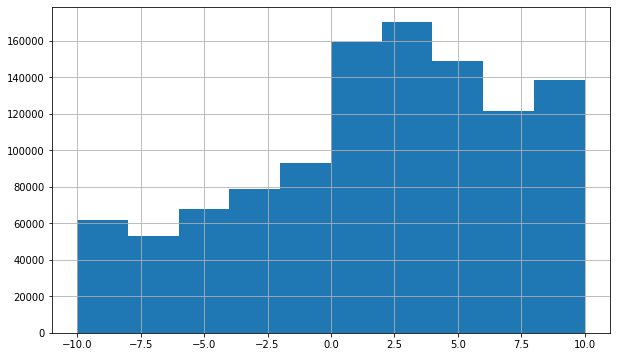

In [50]:
train['Rating'].hist(figsize=(10,6))

In [51]:
pred_test=model.predict(testDataVecs)
sample_df=pd.DataFrame(test,columns=['id'])
sample_df['Rating']=pred_test

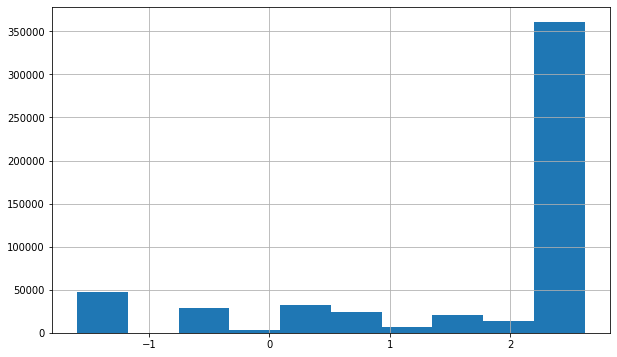

In [52]:
sample_df['Rating'].hist(figsize=(10,6))

In [54]:
sample_df.to_csv('sample_df.csv', index=False)

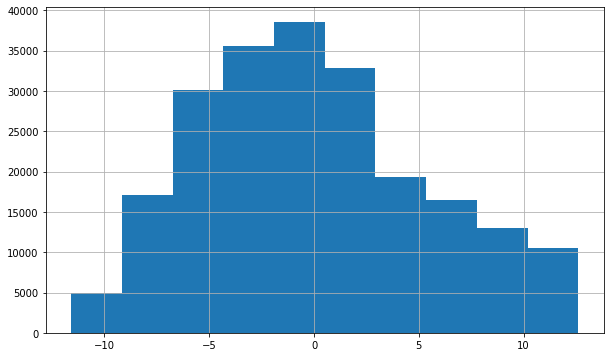

In [55]:
RMSE=pd.DataFrame(prediction,columns=['y_hat'])
RMSE['y_true']=y_test
RMSE['error']=RMSE['y_hat']-RMSE['y_true']
RMSE['error'].hist(figsize=(10,6))